In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
sequence_length = 30

In [4]:
dataset_path = '../dataset_try'
gesture_labels = sorted(os.listdir(dataset_path))

In [6]:
X = []
y = []
for idx, label in enumerate(gesture_labels):
    folder_path = os.path.join(dataset_path, label)
    if not os.path.isdir(folder_path):
        continue
    
    for file_name in os.listdir(folder_path):
        if not file_name.endswith('.npy'):
            continue
        file_path = os.path.join(folder_path, file_name)
        seq_keypoints = np.load(file_path)
        if seq_keypoints.shape[0] != sequence_length or seq_keypoints.shape[1] != 42:
            continue
        
        X.append(seq_keypoints)
        y.append(idx)

X = np.array(X)
y = np.array(y)

print("Total sequences:", X.shape, y.shape)
print("Gesture labels:", gesture_labels)

Total sequences: (720, 30, 42) (720,)
Gesture labels: ['a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'ă', 'đ']


Chuẩn hóa

In [7]:
# Ví dụ tính mean và std của toàn bộ X:
X_flat = X.reshape(-1, 42)          # shape (n_samples * SEQUENCE_LENGTH, 42)
mean = np.mean(X_flat, axis=0, keepdims=True)
std  = np.std(X_flat, axis=0, keepdims=True) + 1e-6

# Áp dụng normalize: (X - mean) / std
X = (X.reshape(-1, 42) - mean) / std
X = X.reshape(-1, sequence_length, 42)

Chia dữ liệu thành train, validation và test

In [10]:
# Bước 1: chia ra train+val (85%) và test (15%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y)

In [11]:
# Bước 2: từ X_trainval lại chia ra train (80% của 85% ≈ 68%) và val (20% của 85% ≈ 17%).
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.15/0.85,  # ≈0.176, để val ~15% tổng
    random_state=42, stratify=y_trainval)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (504, 30, 42) (504,)
Validation: (108, 30, 42) (108,)
Test: (108, 30, 42) (108,)


Mã hóa nhãn

In [12]:
import tensorflow as tf

# Ví dụ với TensorFlow/Keras
num_classes = len(gesture_labels)  # giả sử = 8 (trong ví dụ)
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_onehot   = tf.keras.utils.to_categorical(y_val,   num_classes)
y_test_onehot  = tf.keras.utils.to_categorical(y_test,  num_classes)

Xây dựng mô hình

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = len(gesture_labels)    # ví dụ = 8
SEQUENCE_LENGTH = X_train.shape[1]   # ví dụ = 30
NUM_KEYPOINTS = X_train.shape[2]     # ví dụ = 42

model = models.Sequential([
    layers.Input(shape=(SEQUENCE_LENGTH, NUM_KEYPOINTS)),

    # 1 lớp LSTM 128 units
    layers.LSTM(128, return_sequences=False, name='lstm_1'),
    layers.Dropout(0.3),

    # 1–2 lớp Dense để phân loại
    layers.Dense(64, activation='relu', name='dense_1'),
    layers.Dropout(0.3),

    # Output
    layers.Dense(num_classes, activation='softmax', name='output')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # nếu y_train vẫn là integer
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        87,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,368 (380.34 KB)

 Trainable params: 97,368 (380.34 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.1046 - loss: 3.0959 - val_accuracy: 0.4444 - val_loss: 2.5498
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3520 - loss: 2.4231 - val_accuracy: 0.4722 - val_loss: 1.9224
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5367 - loss: 1.7926 - val_accuracy: 0.7130 - val_loss: 1.3266
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6833 - loss: 1.2801 - val_accuracy: 0.8796 - val_loss: 0.8292
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7785 - loss: 0.8965 - val_accuracy: 0.8889 - val_loss: 0.5802
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8372 - loss: 0.6512 - val_accuracy: 0.9074 - val_loss: 0.3948
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9005 - loss: 0.4537 - val_accuracy: 0.9074 - val_loss: 0.3386
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8948 - loss: 0.4084 - val_accuracy: 0.9444 - v

In [15]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9545 - loss: 0.3121
Test accuracy: 0.9722, Test loss: 0.1936


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


<Figure size 800x800 with 0 Axes>

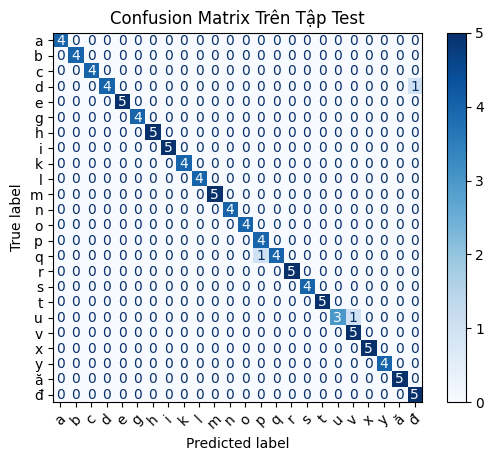

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dự đoán
y_pred_probs = model.predict(X_test)        # shape: (num_test, num_classes)
y_pred = np.argmax(y_pred_probs, axis=1)

# Tính confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=range(num_classes))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gesture_labels)

plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix Trên Tập Test")
plt.show()

In [17]:
model.save('model_tf.keras')

In [18]:
np.save('mean.npy', mean)
np.save('std.npy', std)